# Calibration methods comparison: simulated predictions on 2-simplex

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.optimizers import Adam, SGD

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport flows.normalizing_flows
%aimport calibrators
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot, reliability_diagram, ECE_plot, plot_cal_regions_ternary
from flows.nice import AddCouplingLayer, MLP, ReIndex
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator, TempScalingCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator

In [4]:
%matplotlib inline
np.random.seed(2)

### Generate fake target distribution and simulated predictions

In [5]:
n_samples = 1500

target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.3

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

snt_logits = 0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset

# 0-center logits
snt_logits -= np.mean(snt_logits, axis=1, keepdims=True)

snt_probs = softmax(snt_logits, axis=1)

nll = neg_log_likelihood(snt_probs, target)
ECE = expected_calibration_error(snt_probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))
print("Expected Calibration Error of the classifier predictions: {:.5f}".format(ECE))

Negative log-likelihood of the classifier predictions: 0.83211
Expected Calibration Error of the classifier predictions: 0.24600


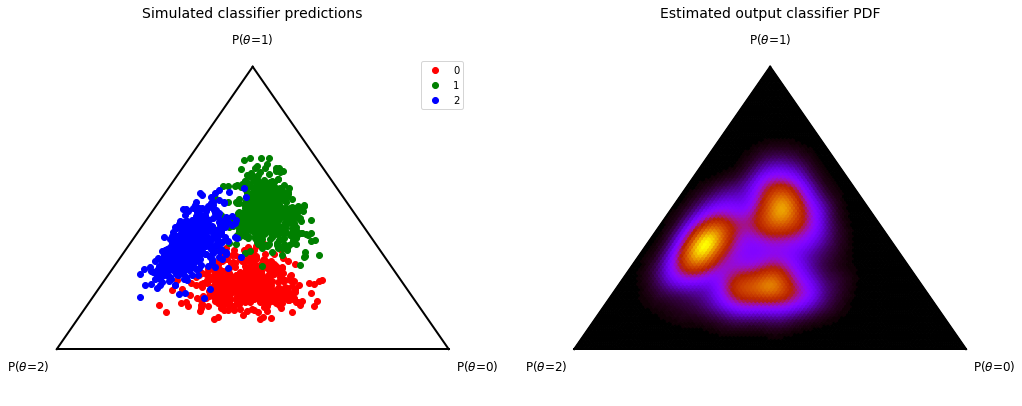

In [6]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(snt_probs, target=target, ax=ax_arr[0], title='Simulated classifier predictions', fontsize=12);
ax_arr[1] = plot_pdf_simplex(snt_probs, scale=100, ax=ax_arr[1], title='Estimated output classifier PDF', fontsize=12);
plt.show()

## Fit calibrators

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fitted PlanarFlow in 49.897s
Fitted RadialFlow in 123.246s


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted NICE in 70.310s


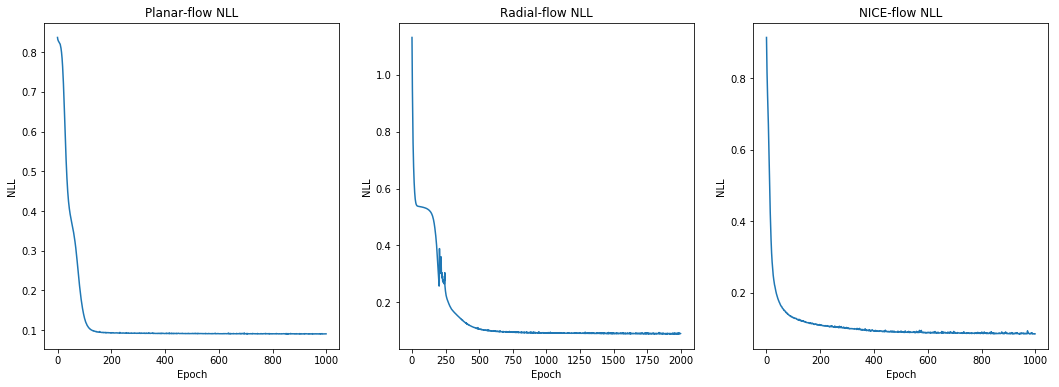

In [7]:
## Temp-Scaling
temp_cal = TempScalingCalibrator(snt_logits, target)
temp_probs = temp_cal.predict(snt_logits)

nll_temp = neg_log_likelihood(temp_probs, target)
ECE_temp = expected_calibration_error(temp_probs, target)


## Multiclass PAV
pav_cal = PAVCalibrator(snt_logits, target)
pav_probs = pav_cal.predict(snt_logits)

nll_pav = neg_log_likelihood(pav_probs, target)
ECE_pav = expected_calibration_error(pav_probs, target)


## MLR
mlr_cal = MLRCalibrator(snt_logits, target)
mlr_probs = mlr_cal.predict(snt_logits)

nll_mlr = neg_log_likelihood(mlr_probs, target)
ECE_mlr = expected_calibration_error(mlr_probs, target)


## Planar flow
t0 = time.time()
pln_cal = PlanarFlowCalibrator(snt_logits, target, layers=10)
print('Fitted PlanarFlow in {:.3f}s'.format(time.time()-t0))
pln_probs = pln_cal.predict(snt_logits)

nll_pln = neg_log_likelihood(pln_probs, target)
ECE_pln = expected_calibration_error(pln_probs, target)


## Radial flow
t0 = time.time()
rdl_cal = RadialFlowCalibrator(snt_logits, target, layers=10, epochs=2000)
print('Fitted RadialFlow in {:.3f}s'.format(time.time()-t0))
rdl_probs = rdl_cal.predict(snt_logits)

nll_rdl = neg_log_likelihood(rdl_probs, target)
ECE_rdl = expected_calibration_error(rdl_probs, target)


## NICE flow
t0 = time.time()
nice_cal = NiceCalibrator(snt_logits, target, layers=4, hidden_size=[6, 6], version=2)
print('Fitted NICE in {:.3f}s'.format(time.time()-t0))
nice_probs = nice_cal.predict(snt_logits)

nll_nice = neg_log_likelihood(nice_probs, target)
ECE_nice = expected_calibration_error(nice_probs, target)


# Plot training NLL
fig, ax_arr = plt.subplots(1, 3, figsize=(18, 6))

ax_arr[0].plot(pln_cal.history.history['loss'])
ax_arr[0].set_title('Planar-flow NLL')
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('Epoch')

ax_arr[1].plot(rdl_cal.history.history['loss'])
ax_arr[1].set_title('Radial-flow NLL')
ax_arr[1].set_ylabel('NLL')
ax_arr[1].set_xlabel('Epoch')

ax_arr[2].plot(nice_cal.history.history['loss'])
ax_arr[2].set_title('NICE-flow NLL')
ax_arr[2].set_ylabel('NLL')
ax_arr[2].set_xlabel('Epoch')

plt.show()

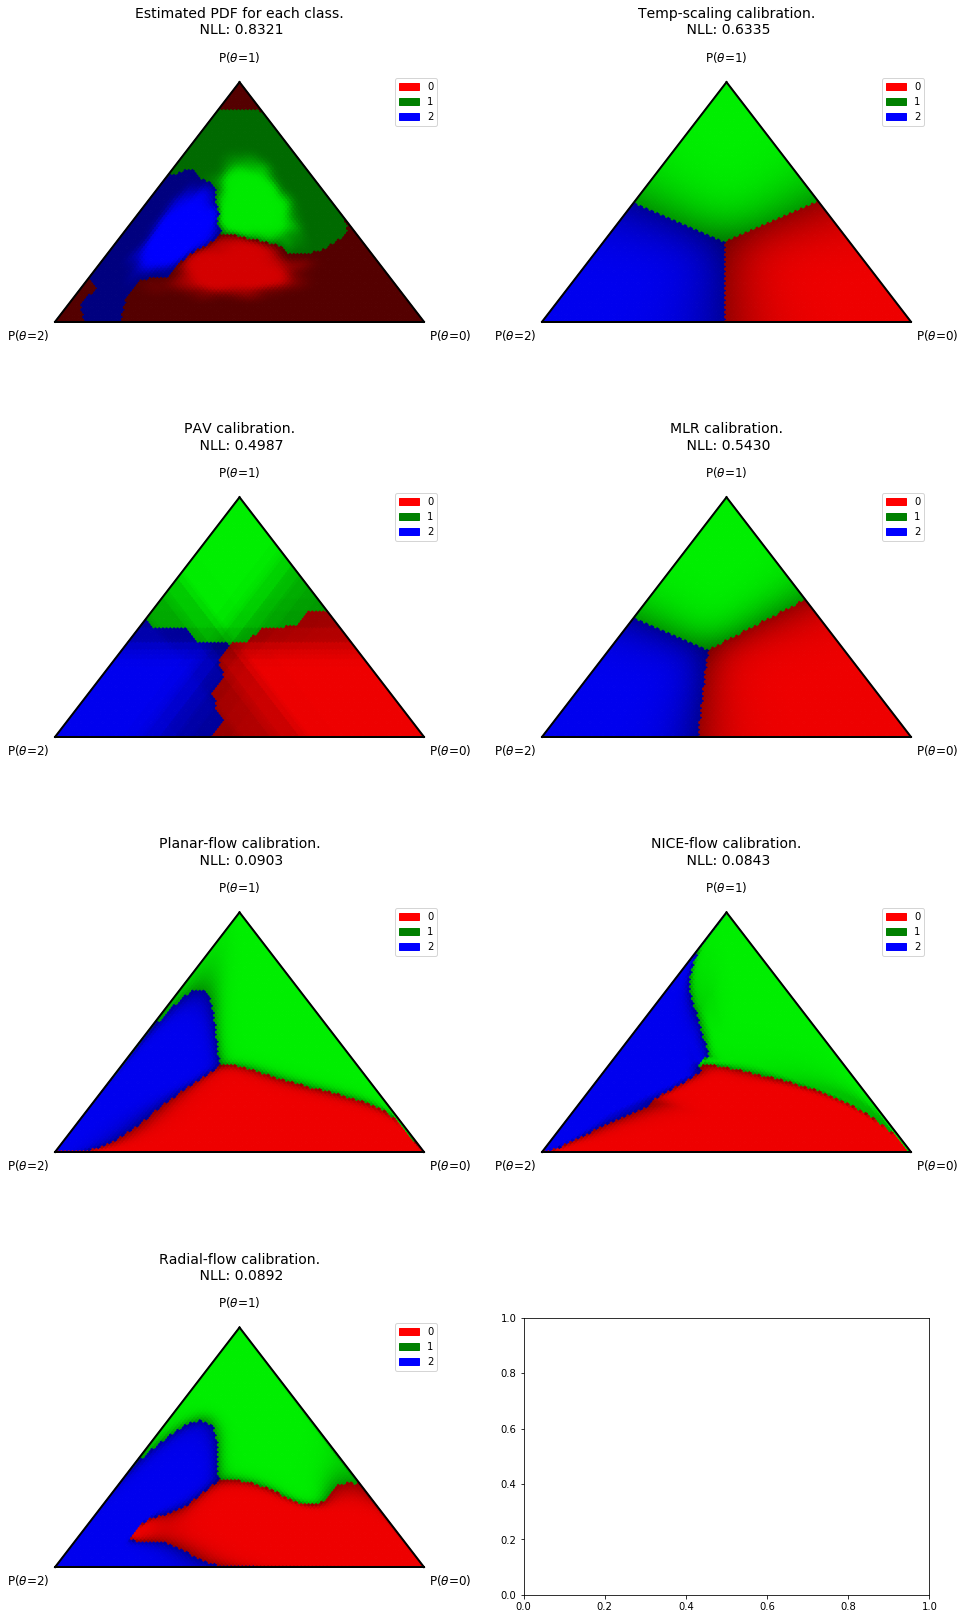

In [8]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})

ax_arr[0, 0] = plot_pdf_simplex(snt_probs, target=target, ax=ax_arr[0, 0], scale=100,
                                title='Estimated PDF for each class.\n NLL: {:.4f}'.format(nll), fontsize=12);
ax_arr[0, 1] = plot_cal_regions_ternary(temp_cal, ax=ax_arr[0, 1], scale=100,
                             title='Temp-scaling calibration.\n NLL: {:.4f}'.format(nll_temp), fontsize=12);
ax_arr[1, 0] = plot_cal_regions_ternary(pav_cal, ax=ax_arr[1, 0], scale=100,
                             title='PAV calibration.\n NLL: {:.4f}'.format(nll_pav), fontsize=12);
ax_arr[1, 1] = plot_cal_regions_ternary(mlr_cal, ax=ax_arr[1, 1], scale=100,
                             title='MLR calibration.\n NLL: {:.4f}'.format(nll_mlr), fontsize=12);
ax_arr[2, 0] = plot_cal_regions_ternary(pln_cal, ax=ax_arr[2, 0], scale=100,
                             title='Planar-flow calibration.\n NLL: {:.4f}'.format(nll_pln), fontsize=12);
ax_arr[2, 1] = plot_cal_regions_ternary(nice_cal, ax=ax_arr[2, 1], scale=100,
                             title='NICE-flow calibration.\n NLL: {:.4f}'.format(nll_nice), fontsize=12);
ax_arr[3, 0] = plot_cal_regions_ternary(rdl_cal, ax=ax_arr[3, 0], scale=100,
                             title='Radial-flow calibration.\n NLL: {:.4f}'.format(nll_rdl), fontsize=12);

plt.show()

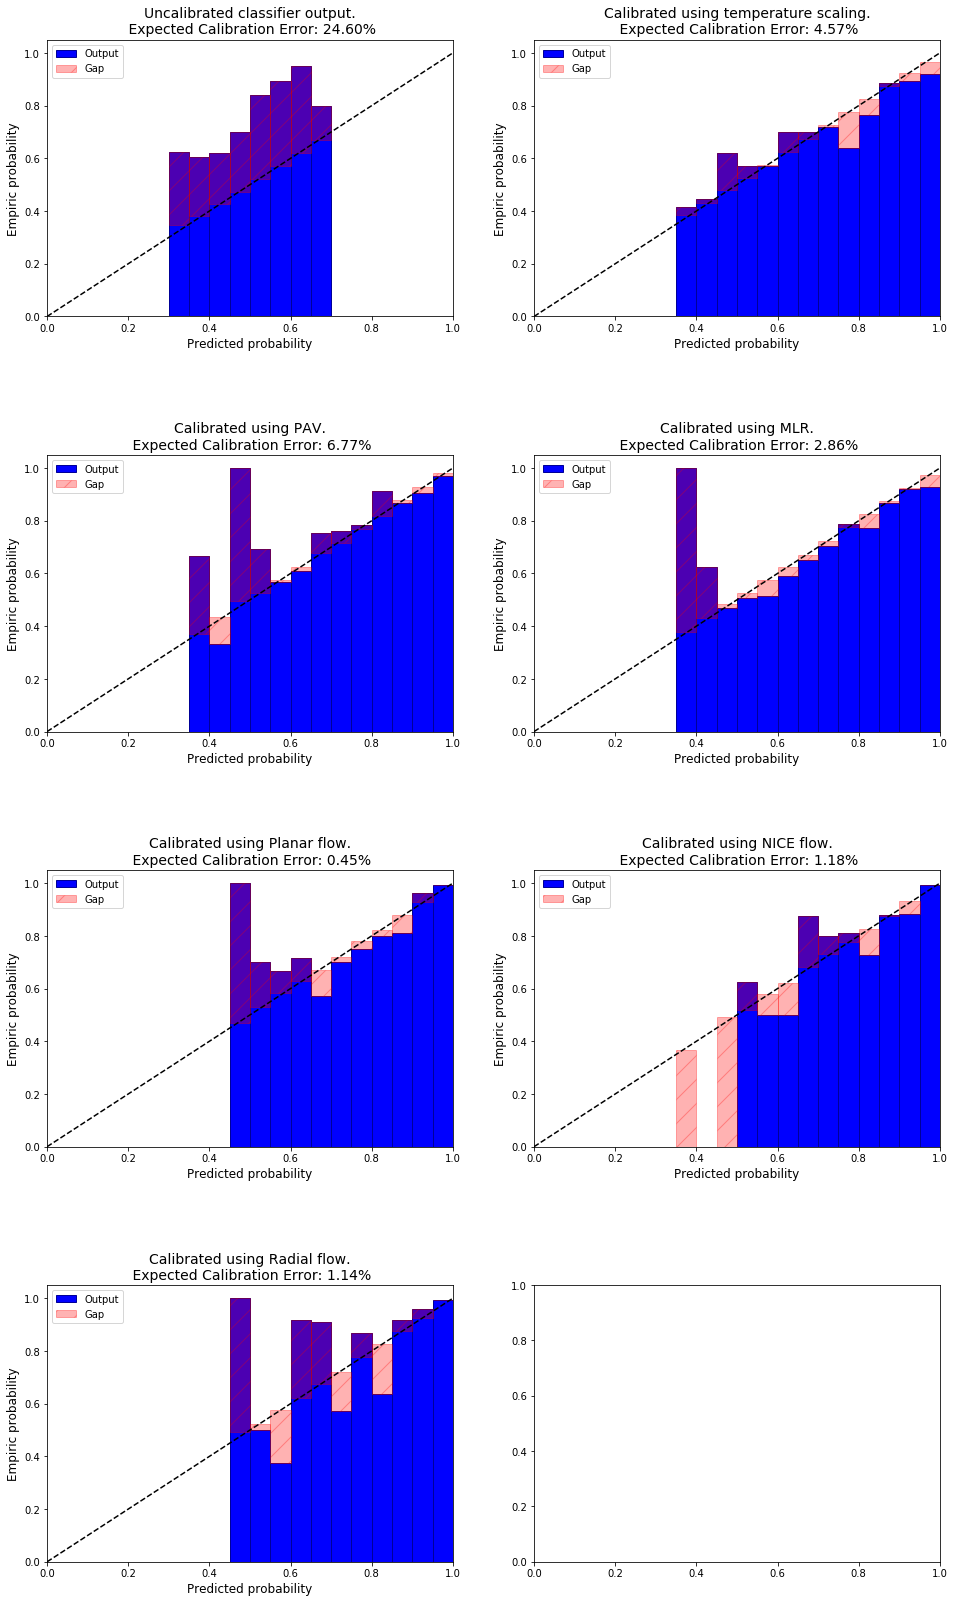

In [9]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(snt_probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n Expected Calibration Error: {:.2%}'.format(ECE), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n Expected Calibration Error: {:.2%}'.format(ECE_temp), fontsize=12);
ax_arr[1, 0] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n Expected Calibration Error: {:.2%}'.format(ECE_pav), fontsize=12);
ax_arr[1, 1] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using MLR.\n Expected Calibration Error: {:.2%}'.format(ECE_mlr), fontsize=12);
ax_arr[2, 0] = reliability_diagram(pln_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using Planar flow.\n Expected Calibration Error: {:.2%}'.format(ECE_pln), fontsize=12);
ax_arr[2, 1] = reliability_diagram(nice_probs, target, ax=ax_arr[2, 1],
                             title='Calibrated using NICE flow.\n Expected Calibration Error: {:.2%}'.format(ECE_nice), fontsize=12);
ax_arr[3, 0] = reliability_diagram(rdl_probs, target, ax=ax_arr[3, 0],
                             title='Calibrated using Radial flow.\n Expected Calibration Error: {:.2%}'.format(ECE_rdl), fontsize=12);

plt.show()

## Visualize 2-simplex after each Planar layer:

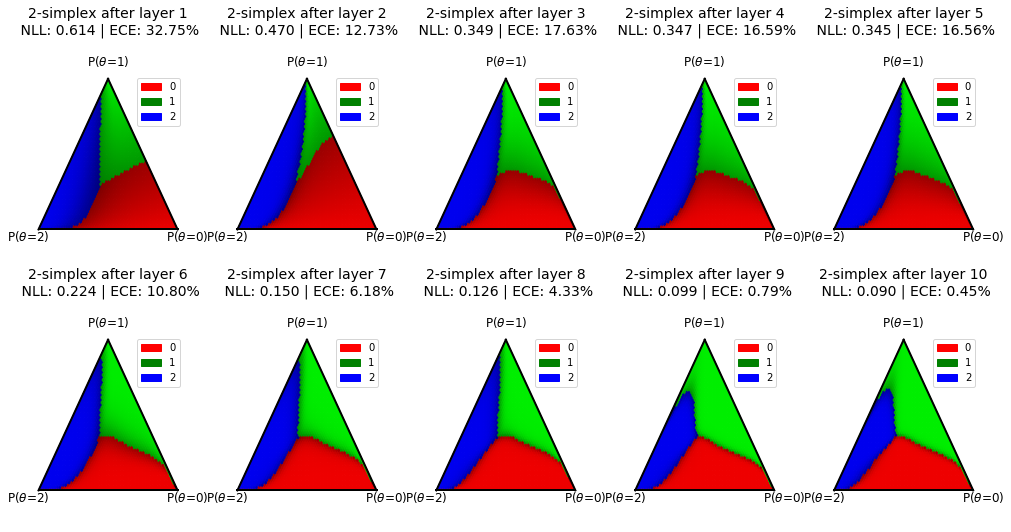

In [10]:
models = []
for layer in pln_cal.flow.forward_model.layers[1:]:
    models.append(Model(
        inputs=pln_cal.flow.forward_model.input,
        outputs=Activation('softmax')(layer.output)
    ))
    
fig, ax_arr = plt.subplots(2, 5, figsize=(17, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

for i, model in enumerate(models):
    nll = neg_log_likelihood(model.predict(snt_logits), target)
    ECE = expected_calibration_error(model.predict(snt_logits), target)
    ax_arr[i//5][i%5] = plot_cal_regions_ternary(model.predict, ax=ax_arr[i//5][i%5], scale=60,
                                                 title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                                 fontsize=12);
    
plt.show()

## Visualize 2-simplex after each Radial layer:

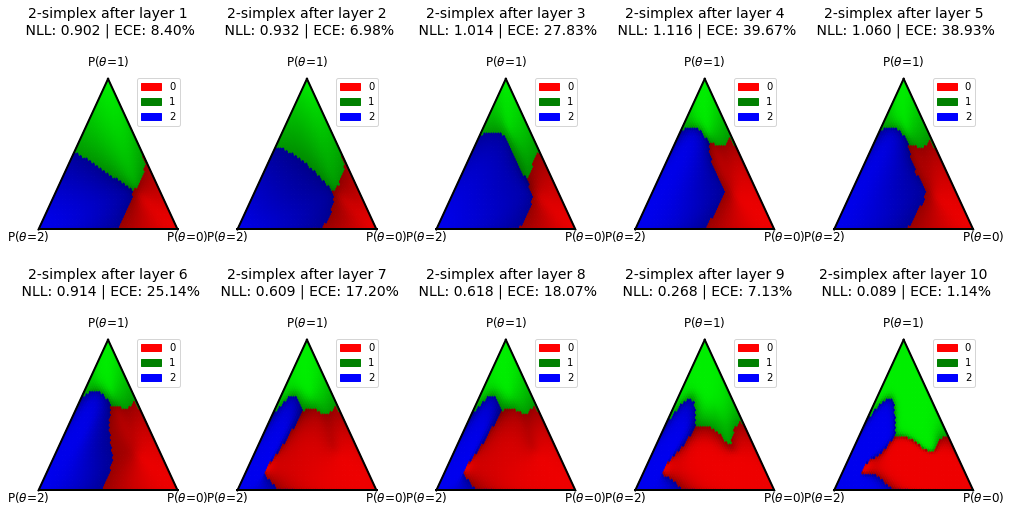

In [11]:
models = []
for layer in rdl_cal.flow.forward_model.layers[1:]:
    models.append(Model(
        inputs=rdl_cal.flow.forward_model.input,
        outputs=Activation('softmax')(layer.output)
    ))
    
fig, ax_arr = plt.subplots(2, 5, figsize=(17, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

for i, model in enumerate(models):
    nll = neg_log_likelihood(model.predict(snt_logits), target)
    ECE = expected_calibration_error(model.predict(snt_logits), target)
    ax_arr[i//5][i%5] = plot_cal_regions_ternary(model.predict, ax=ax_arr[i//5][i%5], scale=60,
                                                 title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                                 fontsize=12);
    
plt.show()